In [93]:
!uv add matplotlib

Resolved 21 packages in 9ms
Audited 18 packages in 0.67ms


In [94]:
from __future__ import annotations
import pandas as pd
import numpy as np
from docx import Document
import matplotlib.pyplot as plt

# Paths (adjust if needed)
STINT_PATH = "./stint_data.csv"
PLAYER_PATH = "./player_data.csv"
DICT_PATH = "./data_dictionary.docx"

stints = pd.read_csv(STINT_PATH)
players = pd.read_csv(PLAYER_PATH)

print("Loaded:")
print("  stints:", stints.shape, "rows x cols")
print("  players:", players.shape, "rows x cols")
print()

required_cols = [
    "game_id", "h_team", "a_team", "minutes", "h_goals", "a_goals",
    "home1", "home2", "home3", "home4",
    "away1", "away2", "away3", "away4"
]
missing = [c for c in required_cols if c not in stints.columns]
if missing:
    raise ValueError(f"stint_data.csv is missing columns: {missing}")

if "player" not in players.columns or "rating" not in players.columns:
    raise ValueError("player_data.csv should have columns: player, rating")

print("Data validation passed")



Loaded:
  stints: (7448, 14) rows x cols
  players: (144, 2) rows x cols

Data validation passed


In [95]:
# List of All Teams
teams = sorted(set(stints["h_team"]).union(set(stints["a_team"])))
print("Number of teams:", len(teams))
print("Teams:", teams)
print()

Number of teams: 12
Teams: ['Argentina', 'Brazil', 'Canada', 'Chile', 'Columbia', 'Denmark', 'France', 'Great.Britain', 'Japan', 'Poland', 'Sweden', 'USA']



In [ ]:
# Build Game-Level Summary
# Each game_id has many stints, we aggregate them into one game result
games = (
    stints.groupby(["game_id", "h_team", "a_team"], as_index=False)
          .agg(
              total_minutes=("minutes", "sum"),
              home_goals=("h_goals", "sum"),
              away_goals=("a_goals", "sum"),
          )
)

# Determine winner
games["winner"] = np.where(
    games["home_goals"] > games["away_goals"], games["h_team"],
    np.where(games["away_goals"] > games["home_goals"], games["a_team"], "TIE")
)

games["home_win"] = (games["winner"] == games["h_team"]).astype(int)
games["away_win"] = (games["winner"] == games["a_team"]).astype(int)
games["tie"] = (games["winner"] == "TIE").astype(int)

print("Games Summary")
print("Number of games:", len(games))
print(games.head(10))
print()

Games Summary
Number of games: 660
   game_id h_team         a_team  total_minutes  home_goals  away_goals  \
0        1    USA          Japan           32.0          42          63   
1        2    USA  Great.Britain           32.0          45          42   
2        3    USA         Canada           32.0          60          28   
3        4    USA         France           32.0          52          33   
4        5    USA        Denmark           32.0          41          53   
5        6    USA         Sweden           32.0          83          44   
6        7    USA         Brazil           32.0          57          33   
7        8    USA       Columbia           32.0          52          39   
8        9    USA         Poland           32.0          49          39   
9       10    USA      Argentina           32.0          64          32   

    winner  home_win  away_win  tie  
0    Japan         0         1    0  
1      USA         1         0    0  
2      USA         1     

Team Win Rates
Current #1 by win rate is Japan (82.7%).
               games_played  wins  ties  win_rate
h_team                                           
Japan                   110    91     0     0.827
USA                     110    79     0     0.718
France                  110    70     0     0.636
Canada                  110    66     0     0.600
Great.Britain           110    66     0     0.600
Poland                  110    65     0     0.591
Brazil                  110    63     0     0.573
Denmark                 110    57     0     0.518
Columbia                110    55     0     0.500
Chile                   110    23     0     0.209
Argentina               110    13     0     0.118
Sweden                  110    12     0     0.109


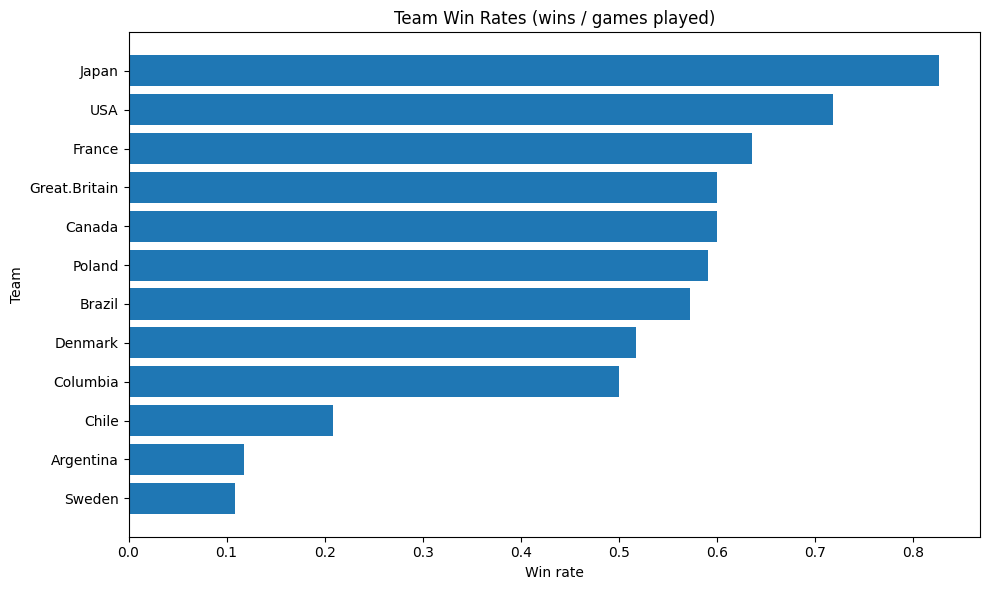

In [ ]:
# Team Win Rates
home_stats = games.groupby("h_team").agg(
    home_games=("game_id", "count"),
    home_wins=("home_win", "sum"),
    home_ties=("tie", "sum"),
)
away_stats = games.groupby("a_team").agg(
    away_games=("game_id", "count"),
    away_wins=("away_win", "sum"),
    away_ties=("tie", "sum"),
)

team_summary = (
    home_stats.join(away_stats, how="outer")
              .fillna(0)
              .assign(
                  games_played=lambda d: d["home_games"] + d["away_games"],
                  wins=lambda d: d["home_wins"] + d["away_wins"],
                  ties=lambda d: d["home_ties"] + d["away_ties"],
                  win_rate=lambda d: np.where(d["games_played"] > 0, d["wins"] / d["games_played"], np.nan),
              )
              .sort_values("win_rate", ascending=False)
)



print("Team Win Rates")
top_team = team_summary.index[0]
top_wr = float(team_summary.loc[top_team, "win_rate"])
print(f"Current #1 by win rate is {top_team} ({top_wr:.1%}).")

print(team_summary[["games_played", "wins", "ties", "win_rate"]].round(3))

# Team win rates (bar chart)
plot_df = team_summary.reset_index().copy()
# After reset_index, the index column name is "h_team"
plot_df = plot_df.sort_values("win_rate", ascending=True)  # horizontal bar reads nicer

plt.figure(figsize=(10, 6))
plt.barh(plot_df["h_team"], plot_df["win_rate"])
plt.xlabel("Win rate")
plt.ylabel("Team")
plt.title("Team Win Rates (wins / games played)")
plt.tight_layout()
plt.show()



In [98]:
# Home Court Advantage Analysis
home_win_rate = games["home_win"].mean()
print("Home Advantage")
print(f"Home win rate: {home_win_rate:.3f} ({home_win_rate*100:.1f}%)")
print()

Home Advantage
Home win rate: 0.571 (57.1%)



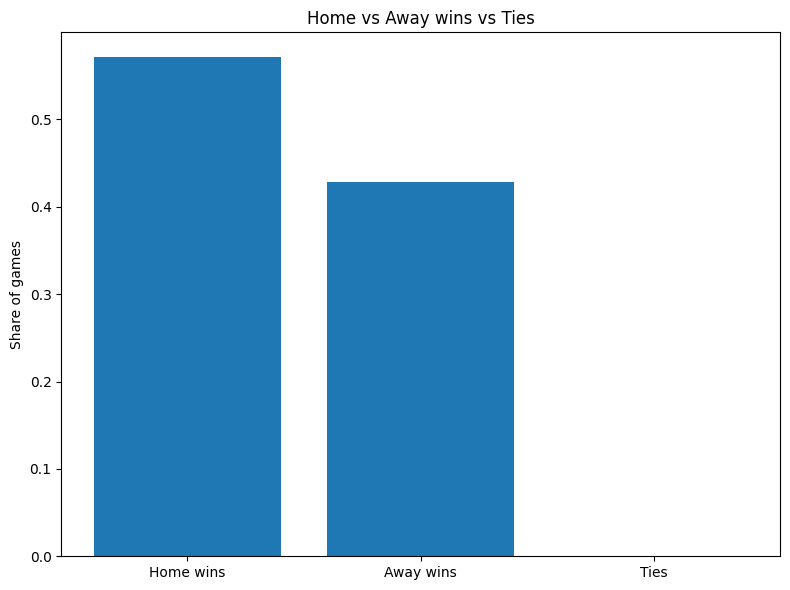

In [99]:
# Home vs Away vs Ties (simple bar chart)
away_win_rate = games["away_win"].mean()
tie_rate = games["tie"].mean()

plt.figure(figsize=(8, 6))
plt.bar(["Home wins", "Away wins", "Ties"], [home_win_rate, away_win_rate, tie_rate])
plt.ylabel("Share of games")
plt.title("Home vs Away wins vs Ties")
plt.tight_layout()
plt.show()

In [100]:
# Overtime Games Analysis
# Standard wheelchair rugby games are ~32 minutes
# Games with total_minutes > 32.1 likely went to overtime
overtime_like = games.loc[games["total_minutes"] > 32.1].sort_values("total_minutes", ascending=False)
print("Overtime Games")
#print()
print(f"Found {len(overtime_like)} overtime-ish games (total minutes > 32.1).")
print(overtime_like[["game_id", "h_team", "a_team", "total_minutes"]].head(20))


Overtime Games
Found 16 overtime-ish games (total minutes > 32.1).
     game_id         h_team         a_team  total_minutes
146      147          Japan         France           38.0
355      356       Columbia         Canada           38.0
651      652          Chile  Great.Britain           38.0
176      177         France            USA           35.0
211      212         Brazil  Great.Britain           35.0
228      229       Columbia         Poland           35.0
474      475         Brazil          Japan           35.0
402      403            USA         Brazil           35.0
25        26  Great.Britain         France           35.0
255      256          Chile  Great.Britain           35.0
262      263          Chile         Poland           35.0
496      497         Poland          Japan           35.0
604      605         Sweden          Chile           35.0
30        31  Great.Britain         Poland           35.0
470      471         Sweden         Poland           35.0
624  

Canada Head-to-Head Analysis Overview
Results: Best matchup: Argentina (90.0%), hardest: Japan (30.0%).
         opponent  games  wins  losses  ties  canada_goals  opp_goals  \
0       Argentina     10     9       1     0           563        359   
9          Sweden     10     9       1     0           602        429   
4         Denmark     10     9       1     0           554        483   
2           Chile     10     7       3     0           626        552   
1          Brazil     10     6       4     0           544        477   
5          France     10     6       4     0           504        521   
3        Columbia     10     5       5     0           500        473   
6   Great.Britain     10     5       5     0           476        511   
10            USA     10     4       6     0           464        571   
8          Poland     10     3       7     0           454        484   
7           Japan     10     3       7     0           390        591   

    goal_diff  win_

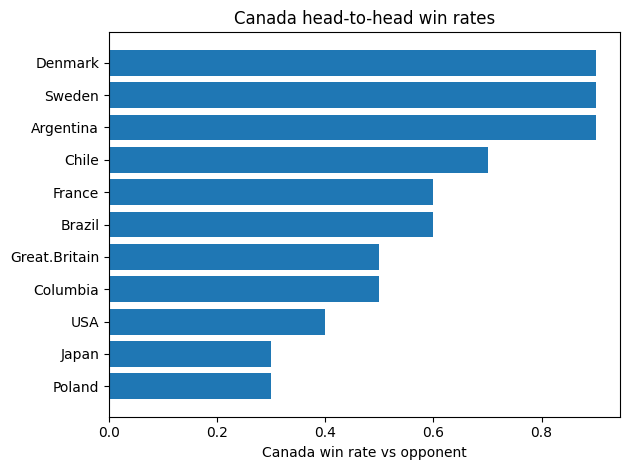

In [101]:
# Canada Head-to-Head Analysis
def canada_head_to_head(games_df: pd.DataFrame, canada_name: str = "Canada") -> pd.DataFrame:
    """Analyze Canada's performance against each opponent."""
    g = games_df.copy()
    # Filter games including Canada
    mask = (g["h_team"] == canada_name) | (g["a_team"] == canada_name)
    g = g.loc[mask].copy()

    # Opponent column
    g["opponent"] = np.where(g["h_team"] == canada_name, g["a_team"], g["h_team"])

    # Canada score & opponent score
    g["canada_goals"] = np.where(g["h_team"] == canada_name, g["home_goals"], g["away_goals"])
    g["opp_goals"] = np.where(g["h_team"] == canada_name, g["away_goals"], g["home_goals"])

    # Result
    g["canada_win"] = (g["canada_goals"] > g["opp_goals"]).astype(int)
    g["canada_loss"] = (g["canada_goals"] < g["opp_goals"]).astype(int)
    g["canada_tie"] = (g["canada_goals"] == g["opp_goals"]).astype(int)

    summary = (
        g.groupby("opponent", as_index=False)
         .agg(
             games=("game_id", "count"),
             wins=("canada_win", "sum"),
             losses=("canada_loss", "sum"),
             ties=("canada_tie", "sum"),
             canada_goals=("canada_goals", "sum"),
             opp_goals=("opp_goals", "sum"),
         )
    )
    summary["goal_diff"] = summary["canada_goals"] - summary["opp_goals"]
    summary["win_rate"] = np.where(summary["games"] > 0, summary["wins"] / summary["games"], np.nan)
    return summary.sort_values(["win_rate", "goal_diff"], ascending=False)

h2h = canada_head_to_head(games, "Canada")
print("Canada Head-to-Head Analysis Overview")
if len(h2h) > 0:
    best_opp = h2h.iloc[0]["opponent"]
    best_wr = float(h2h.iloc[0]["win_rate"])
    worst_opp = h2h.iloc[-1]["opponent"]
    worst_wr = float(h2h.iloc[-1]["win_rate"])
    print(f"Results: Best matchup: {best_opp} ({best_wr:.1%}), hardest: {worst_opp} ({worst_wr:.1%}).")
else:
    print("No Canada games found, so head-to-head was skipped.")

print(h2h.round(3))
print()

# Canada win rate vs each opponent (bar chart)
if len(h2h) > 0:
    h2h_plot = h2h.sort_values("win_rate", ascending=True)
    plt.figure()
    plt.barh(h2h_plot["opponent"], h2h_plot["win_rate"])
    plt.xlabel("Canada win rate vs opponent")
    plt.title("Canada head-to-head win rates")
    plt.tight_layout()
    plt.show()



Canada player impact computed (min 30 minutes); top player is Canada_p9 at 3.43 goal-diff per 10 minutes.
Canada Player Impact (Top Performers)
        player   minutes  goals_for  goals_against  goal_diff  diff_per_min  \
11   Canada_p9  1158.983       2065           1667        398         0.343   
2   Canada_p11  1284.482       2166           1754        412         0.321   
5    Canada_p3  1255.327       1991           1752        239         0.190   
4    Canada_p2  1438.466       2491           2370        121         0.084   
9    Canada_p7  1045.205       1668           1585         83         0.079   
8    Canada_p6  1330.632       2093           2053         40         0.030   
7    Canada_p5   976.370       1620           1598         22         0.023   
1   Canada_p10  1235.527       1930           1946        -16        -0.013   
3   Canada_p12  1436.848       2165           2228        -63        -0.044   
0    Canada_p1   866.687       1368           1431        -63     

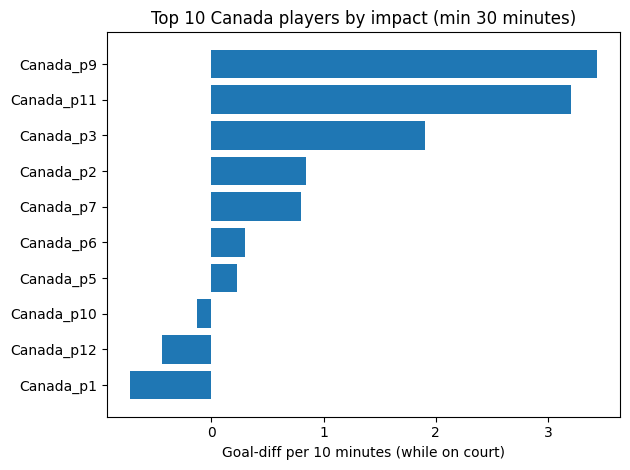

In [102]:
# Canada Player Impact Analysis
HOME_PLAYER_COLS = ["home1", "home2", "home3", "home4"]
AWAY_PLAYER_COLS = ["away1", "away2", "away3", "away4"]

def canada_player_impact(stints_df: pd.DataFrame, canada_name: str = "Canada") -> pd.DataFrame:
    """
    Compute individual player impact for Canada players.
    Metrics: minutes, goals_for, goals_against, goal_diff, diff_per_10_min
    """
    # Separate stints where Canada is home vs away
    home = stints_df.loc[stints_df["h_team"] == canada_name].copy()
    away = stints_df.loc[stints_df["a_team"] == canada_name].copy()

    # For Canada home stints: goals_for = h_goals, goals_against = a_goals
    home_long = home.melt(
        id_vars=["minutes", "h_goals", "a_goals"],
        value_vars=HOME_PLAYER_COLS,
        var_name="slot",
        value_name="player",
    ).dropna(subset=["player"])
    home_long["goals_for"] = home_long["h_goals"]
    home_long["goals_against"] = home_long["a_goals"]

    # For Canada away stints: goals_for = a_goals, goals_against = h_goals
    away_long = away.melt(
        id_vars=["minutes", "h_goals", "a_goals"],
        value_vars=AWAY_PLAYER_COLS,
        var_name="slot",
        value_name="player",
    ).dropna(subset=["player"])
    away_long["goals_for"] = away_long["a_goals"]
    away_long["goals_against"] = away_long["h_goals"]

    # Combine and aggregate by player
    long = pd.concat([home_long[["player", "minutes", "goals_for", "goals_against"]],
                      away_long[["player", "minutes", "goals_for", "goals_against"]]],
                     ignore_index=True)

    impact = (
        long.groupby("player", as_index=False)
            .agg(
                minutes=("minutes", "sum"),
                goals_for=("goals_for", "sum"),
                goals_against=("goals_against", "sum"),
            )
    )
    impact["goal_diff"] = impact["goals_for"] - impact["goals_against"]
    impact["diff_per_min"] = np.where(impact["minutes"] > 0, impact["goal_diff"] / impact["minutes"], np.nan)
    impact["diff_per_10_min"] = impact["diff_per_min"] * 10

    # Attach player ratings
    impact = impact.merge(players, on="player", how="left")

    return impact.sort_values("diff_per_10_min", ascending=False)

impact = canada_player_impact(stints, "Canada")

MIN_MINUTES = 30
impact_big = impact.loc[impact["minutes"] >= MIN_MINUTES].copy()

if len(impact_big) > 0:
    best_player = impact_big.iloc[0]["player"]
    best_val = float(impact_big.iloc[0]["diff_per_10_min"])
    print(f"Canada player impact computed (min {MIN_MINUTES} minutes); top player is {best_player} at {best_val:.2f} goal-diff per 10 minutes.")
else:
    print(f"No Canada players reached {MIN_MINUTES} minutes, so player ranking is small-sample.")


print("Canada Player Impact (Top Performers)")
print(impact.head(15).round(3))
print()

print("Canada Player Impact (Bottom Performers)")
print(impact.tail(15).round(3))
print()



TOP_N_PLAYERS = 10
if len(impact_big) > 0:
    pplot = impact_big.head(TOP_N_PLAYERS).sort_values("diff_per_10_min", ascending=True)
    plt.figure()
    plt.barh(pplot["player"], pplot["diff_per_10_min"])
    plt.xlabel("Goal-diff per 10 minutes (while on court)")
    plt.title(f"Top {TOP_N_PLAYERS} Canada players by impact (min {MIN_MINUTES} minutes)")
    plt.tight_layout()
    plt.show()

Canada Lineup Performance (minutes >= 10)
Canada lineup impact computed (min 10 minutes); best lineup is Canada_p11|Canada_p2|Canada_p3|Canada_p7 at 17.10 goal-diff per 10 minutes.


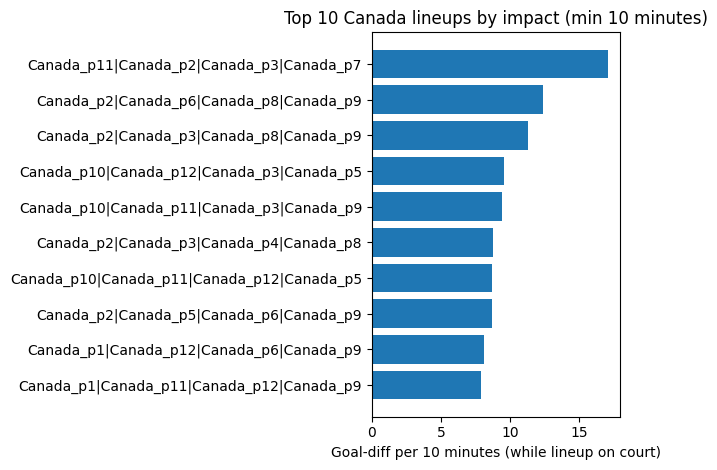

In [103]:
# Canada 4-Player Lineup Performance Analysis
def canada_lineup_performance(stints_df: pd.DataFrame, canada_name: str = "Canada") -> pd.DataFrame:
    """
    Analyze performance of 4-player lineups for Canada.
    Each stint has 4 players; we treat a lineup as an unordered set.
    """
    home = stints_df.loc[stints_df["h_team"] == canada_name].copy()
    away = stints_df.loc[stints_df["a_team"] == canada_name].copy()

    def lineup_key(row: pd.Series, cols: list[str]) -> str:
        # Sort names so same lineup in different order counts as same lineup
        return "|".join(sorted([row[c] for c in cols]))

    if len(home) > 0:
        home["lineup"] = home.apply(lambda r: lineup_key(r, HOME_PLAYER_COLS), axis=1)
        home["goals_for"] = home["h_goals"]
        home["goals_against"] = home["a_goals"]

    if len(away) > 0:
        away["lineup"] = away.apply(lambda r: lineup_key(r, AWAY_PLAYER_COLS), axis=1)
        away["goals_for"] = away["a_goals"]
        away["goals_against"] = away["h_goals"]

    combined = pd.concat(
        [
            home[["lineup", "minutes", "goals_for", "goals_against"]],
            away[["lineup", "minutes", "goals_for", "goals_against"]],
        ],
        ignore_index=True,
    )

    perf = (
        combined.groupby("lineup", as_index=False)
                .agg(
                    minutes=("minutes", "sum"),
                    goals_for=("goals_for", "sum"),
                    goals_against=("goals_against", "sum"),
                )
    )
    perf["goal_diff"] = perf["goals_for"] - perf["goals_against"]
    perf["diff_per_min"] = np.where(perf["minutes"] > 0, perf["goal_diff"] / perf["minutes"], np.nan)
    perf["diff_per_10_min"] = perf["diff_per_min"] * 10

    return perf.sort_values("diff_per_10_min", ascending=False)

lineups = canada_lineup_performance(stints, "Canada")

# Filter lineups by minimum minutes to avoid small sample sizes
MIN_LINEUP_MINUTES = 10
lineups_big = lineups.loc[lineups["minutes"] >= MIN_LINEUP_MINUTES].copy()

print(f"Canada Lineup Performance (minutes >= {MIN_LINEUP_MINUTES})")

if len(lineups_big) > 0:
    best_lineup = lineups_big.iloc[0]["lineup"]
    best_ld = float(lineups_big.iloc[0]["diff_per_10_min"])
    print(f"Canada lineup impact computed (min {MIN_LINEUP_MINUTES} minutes); best lineup is {best_lineup} at {best_ld:.2f} goal-diff per 10 minutes.")
else:
    print(f"No Canada lineups reached {MIN_LINEUP_MINUTES} minutes, so lineup ranking is small-sample.")


#print(lineups_big.head(15).round(3))

TOP_N_LINEUPS = 10
if len(lineups_big) > 0:
    lplot = lineups_big.head(TOP_N_LINEUPS).sort_values("diff_per_10_min", ascending=True)
    plt.figure()
    plt.barh(lplot["lineup"], lplot["diff_per_10_min"])
    plt.xlabel("Goal-diff per 10 minutes (while lineup on court)")
    plt.title(f"Top {TOP_N_LINEUPS} Canada lineups by impact (min {MIN_LINEUP_MINUTES} minutes)")
    plt.tight_layout()
    plt.show()

In [104]:
# Final Rankings: Strongest Teams
print("Likely Strongest Teams (by win_rate)")
ranked = team_summary[["games_played", "wins", "win_rate"]].copy()
ranked["win_rate"] = ranked["win_rate"].round(3)
print(ranked.head(12))
print()

Likely Strongest Teams (by win_rate)
               games_played  wins  win_rate
h_team                                     
Japan                   110    91     0.827
USA                     110    79     0.718
France                  110    70     0.636
Canada                  110    66     0.600
Great.Britain           110    66     0.600
Poland                  110    65     0.591
Brazil                  110    63     0.573
Denmark                 110    57     0.518
Columbia                110    55     0.500
Chile                   110    23     0.209
Argentina               110    13     0.118
Sweden                  110    12     0.109

